[Reference](https://towardsdatascience.com/achieve-better-classification-results-with-classificationthresholdtuner-39c5d454637e)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, brier_score_loss, auc, roc_auc_score, roc_curve, \
    RocCurveDisplay, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from IPython import get_ipython
from IPython.display import display, Markdown
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def is_notebook():
    """
    Determine if we are currently operating in a notebook, such as Jupyter. Returns True if so, False otherwise.
    """
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type
    except NameError:
        return False      # Probably standard Python interpreter


# This tool will generally be used within a notebook. In that case, the notebook should control the display settings.
if not is_notebook():
    pd.set_option('display.width', 32000)
    pd.set_option('display.max_columns', 3000)
    pd.set_option('display.max_colwidth', 3000)
    pd.set_option('display.max_rows', 5000)


class ClassificationThresholdTuner:
    def __init__(self):
        self.colors = ['lightseagreen', 'blue', 'olive', 'brown', 'goldenrod', 'purple', 'pink', 'grey',
                       'indigo', 'orchid', 'cyan', 'lightcoral', 'darksalmon', 'chocalate', 'peachpuff',
                       'teal', 'lime', 'turquoise', 'darkslategrey', 'skyblue', 'slateblue', 'thistle', 'plum',
                       'orange']

    @staticmethod
    def print_stats_labels(y_true, target_classes, y_pred):
        """
        Display basic metrics related to the predictions. This is method is called by print_stats_proba(), but can
        be called directly if the labels have been set elsewhere.

        :param y_true: array of strings.
            True labels for each record
        :param target_classes: array of strings.
            Set of labels. Specified to ensure the output is presented in a sensible order.
        :param y_pred: array of strings
            Predicted labels for each record
        :return: None
        """

        # Ensure y_true and y_pred are in the same format
        y_true = pd.Series(y_true).astype(str)
        y_pred = pd.Series(y_pred).astype(str)
        target_classes = [str(x) for x in target_classes]

        # Print a summary of the basic binary metrics: precision, recall, F1
        prec_arr = precision_score(y_true, y_pred, labels=target_classes, average=None)
        rec_arr  = recall_score(y_true, y_pred, labels=target_classes, average=None)
        f1_arr   = f1_score(y_true, y_pred, labels=target_classes, average=None)

        display_df = pd.DataFrame(columns=['Metric'] + target_classes)
        display_df = pd.concat([display_df, pd.DataFrame([['Precision'] + prec_arr.tolist()], columns=display_df.columns)])
        display_df = pd.concat([display_df, pd.DataFrame([['Recall']    + rec_arr.tolist()],  columns=display_df.columns)])
        display_df = pd.concat([display_df, pd.DataFrame([['F1']        + f1_arr.tolist()],   columns=display_df.columns)])
        display_df['Macro'] = [precision_score(y_true, y_pred, average='macro'),
                               recall_score(y_true, y_pred, average='macro'),
                               f1_score(y_true, y_pred, average='macro')]
        if is_notebook():
            display(display_df)
        else:
            print(display_df)

        # Display a confusion matrix
        n_classes = len(target_classes)
        fig, ax = plt.subplots(figsize=(max(3, n_classes*1.1), max(3, n_classes*1.1)))
        cm = confusion_matrix(y_true, y_pred, labels=target_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
        disp.plot(cmap='Blues', values_format=',', xticks_rotation="vertical", ax=ax)
        plt.title("Confusion Matrix")
        plt.show()

    @staticmethod
    def print_stats_table(y_true, target_classes, y_pred_proba, num_ranges=10):
        """
        Currently, this is available only for binary classification. It provides a breakdown of the precision and
        recall (as well as other statistics) for each range of the predicted probabilities. For example, if 10 ranges
        are used and y_pred_proba is evenly distributed from 0.0 to 1.0, then the first range will cover predicted
        probabilities between 0.9 and 1.0; the next range will cover predicted probabilities between 0.8 and 0.9, and
        so on.

        For each range, this displays the precision (the number of positive records out of the total number of records
        in this range of predicted probabilities) and the recall (the number of positive records in this range out of
        the total number of positive examples).

        The cumulative precision and cumulative recall for each range is also shown, giving insight into setting
        the threshold at the low end of each range. The cumulative values assume we start first with high probabilities,
        and then consider adding lower probabilities, accumulating more predictions for the positive class.

        A plot of the cumulative precision and recall at each probability is also displayed.

        :param y_true: array of strings
            True labels for each record
        :param target_classes: array of strings
            Set of labels. Specified to allow displaying the positive class by name.
        :param y_pred_proba: array of floats
            Predicted labels for each record
        :param num_ranges: int
            The number of rows in the table displayed.

        :return: None
        """

        if len(target_classes) > 2:
            print("This method is currently available only for binary classification")

        y_true = pd.Series(y_true).astype(str)
        y_pred_proba = np.array(y_pred_proba)
        target_classes = [str(x) for x in target_classes]

        if y_pred_proba.ndim == 2:
            y_pred_proba = y_pred_proba[:, 1]

        d = pd.DataFrame({"Y": y_true, "Proba": y_pred_proba})
        total_class_1 = y_true.tolist().count(target_classes[1])
        d['Rank'] = d['Proba'].rank(pct=True)
        size_range = 1.0 / num_ranges
        start_range = 0.0
        end_range = size_range
        rows = []
        for i in range(num_ranges):
            sub_d = d[(d['Rank'] >= start_range) & (d['Rank'] < end_range)]
            rows.append([start_range,
                         end_range,
                         sub_d['Proba'].min(),
                         sub_d['Proba'].max(),
                         sub_d['Y'].tolist().count(target_classes[0]),
                         sub_d['Y'].tolist().count(target_classes[1]),
                         len(sub_d),
                         (sub_d['Y'].tolist().count(target_classes[1]) / len(sub_d)) if len(sub_d) else 0,
                         sub_d['Y'].tolist().count(target_classes[1]) / total_class_1
                         ])
            start_range = end_range
            end_range = end_range + size_range
            if (end_range + size_range) > 100.0:
                end_range = 100.0

        display_df = pd.DataFrame(
            rows,
            columns=['Start Range %',
                     'End Range %',
                     'Min Probability',
                     'Max Probability',
                     f'Count {target_classes[0]}',
                     f'Count {target_classes[1]}',
                     'Total Count',
                     'Precision',
                     'Recall'
                     ]
        )
        display_df = display_df.iloc[::-1]
        display_df = display_df.reset_index(drop=True)
        display_df[f'Cumulative Count {target_classes[1]}'] = display_df[f'Count {target_classes[1]}'].cumsum()
        display_df[f'Cumulative Total Count'] = display_df['Total Count'].cumsum()
        display_df['Cumulative Precision'] = display_df[f'Cumulative Count {target_classes[1]}'] / \
                                             display_df[f'Cumulative Total Count']
        display_df['Cumulative Recall'] = display_df[f'Cumulative Count {target_classes[1]}'] / total_class_1

        if is_notebook():
            display(display_df)
        else:
            print(display_df)

        display_df = display_df.dropna()
        display_df['Mid Probability'] = (display_df['Min Probability'] + display_df['Max Probability']) / 2.0
        fig, ax = plt.subplots()
        sns.lineplot(x=display_df['Mid Probability'], y=display_df['Cumulative Precision'], label='Cumulative Precision')
        sns.lineplot(x=display_df['Mid Probability'], y=display_df['Cumulative Recall'], label='Cumulative Recall')
        ax.set_ylabel("")
        ax.set_xlabel(f"Predicted Probability of '{target_classes[1]}'")
        plt.show()

    def print_stats_proba(self, y_true, target_classes, y_pred_proba, default_class=None, thresholds=None):
        """
        Presents a summary of the quality of the predicted probabilities. This calls print_stats_labels() using the
        threshold provided if any is; and using 0.5 otherwise.

        This then presents 2 scores related to the predicted probabilities: brier score, AUROC.

        It also plots: AUROC curve, histogram, and swarm plot.

        :param y_true: array of strings
            True labels for each record
        :param target_classes: array of strings
            A list of the unique values. Must include all values in y_true, though may include
            additional values not in y_true. In the case of binary classification where y_pred_proba contains only
            a series of values, we assume target_values contains first the negative class and second the positive class,
            with the probabilities representing the probabilities of the positive class.
        :param y_pred_proba: array of floats
            If target_values contains 3 or more values, y_pred_proba must be a 2d matrix with a
            row for each record, each with a probability for each class. If target_values contains only 2 values,
            y_pred_proba may be in either this format or a single array of probabilities, representing the probability
            of the 2nd of the two values in target_value
        :param thresholds: float or array of floats
            For binary classification should be a float. For multiclass classification, should be an
            array of floats, with a value for each class (the default class can be set to 0.0). If set to None, the
            default behaviour will be used to determine the class predictions.
        :return: None
        """

        def two_classes():
            nonlocal thresholds
            nonlocal d
            nonlocal y_pred_proba

            # Ensure the predictions are in a 1d array, though a 2d array may be passed
            if y_pred_proba.ndim == 2:
                y_pred_proba = y_pred_proba[:, 1]

            d['Pred_Proba'] = y_pred_proba

            # Use the default threshold if not provided
            if not thresholds:
                threshold = 0.5
            else:
                threshold = thresholds

            # Ensure y_true is in {0, 1} format
            y_true_zero_one = y_true.map({target_classes[0]: 0, target_classes[1]: 1})

            display_df = pd.DataFrame(
                [['Brier Score', brier_score_loss(y_true_zero_one, y_pred_proba)],
                 ['AUROC',       roc_auc_score(   y_true_zero_one, y_pred_proba)]],
                columns=['Metric', 'Score']
            )
            if is_notebook():
                display(display_df)
            else:
                print(display_df)

            fig, ax = plt.subplots()
            fpr, tpr, roc_thresholds = roc_curve(y_true_zero_one, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='')
            roc_display.plot(ax=ax)
            plt.legend().remove()
            plt.title(f"Area Under ROC Curve (point shown using threshold of {threshold:.5f})")

            # Display an indication of where the current threshold is
            self.__add_roc_lines(fpr, tpr, roc_thresholds, threshold, ax)
            plt.show()

            fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 7))
            for label_idx, label in enumerate(true_labels):
                d_sub = d[d['Y'] == label]
                sns.histplot(d_sub['Pred_Proba'], color=self.colors[label_idx], alpha=0.4, ax=ax[0])
            ax[0].axvline(threshold)
            swarm_ax = ax[1]

            d_sample = self.__get_sample_df(d, target_classes)

            swarm_dot_size = self.__get_swarmplot_dot_size(len(d_sample), y_true)
            d, colors = self.__get_colour_code_binary(d_sample, target_classes, threshold)
            sns.swarmplot(data=d, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, palette=colors,
                          hue='colour_code', order=target_classes, ax=swarm_ax)

            swarm_ax.axvline(threshold)
            swarm_ax.get_legend().remove()
            plt.suptitle("Distribution of Prediction Probabilities by True Class")
            plt.tight_layout()
            plt.show()

        def two_classes_horizontal(target_class_idx, y_true_orig, target_classes_orig, y_pred_proba_orig, cm):
            """
            Called only in the multi-class case. This is called once for each class.
            """

            def styling_flagged_rows(x, flagged_cell, colour):
                df_styler = pd.DataFrame('background-color: white; color: red', index=x.index, columns=x.columns)
                df_styler.iloc[0, flagged_cell] = f'background-color: white; color: {colour}; border: solid thin'
                for col_name in x.columns:
                    if x.loc[0, col_name] == 0:
                        df_styler.loc[0, col_name] = f'background-color: white; color: gray'
                return df_styler

            nonlocal thresholds

            # Ensure y_true is in {0, 1} format, necessary to calculate brier score and AUROC
            y_true_zero_one = y_true.map({target_classes[0]: 0, target_classes[1]: 1})

            display_df = pd.DataFrame(
                [['Brier Score', brier_score_loss(y_true_zero_one, y_pred_proba)],
                 ['AUROC',       roc_auc_score(   y_true_zero_one, y_pred_proba)]],
                columns=['Metric', 'Score']
            )
            msg = (f"Brier score and AUROC calculated based on predicting '{target_classes[1]}', "
                   f"vs not '{target_classes[1]}', so calculated as a two-class problem.")
            if is_notebook():
                display(display_df)
                display(Markdown(f'{msg}'))
            else:
                print(display_df)
                print(msg)

            cm_row_df = pd.DataFrame([cm[target_class_idx]], columns=target_classes_orig)
            msg = (f"Displaying the row of the confusion matrix for the current target ({target_classes[1]}). This "
                   f"shows which classes were predicted when {target_classes[1]} is true. This corresponds to the "
                   f"row for {target_classes[1]} in the swarm plot and explains the predictions for the red dots in "
                   f"this row. Red dots in other rows in the swarm plot may predict any class other than the correct "
                   f"class.")
            if is_notebook():
                display(Markdown(f'<br><br>{msg}'))
                display(cm_row_df.style.apply(
                    styling_flagged_rows,
                    flagged_cell=target_class_idx,
                    colour=self.colors[target_class_idx],
                    axis=None))
            else:
                print(msg)
                print(cm_row_df)

            # Create a dataframe to represent the true labels and the probabilities of the current target class.
            d = pd.DataFrame({"Y": y_true_orig,
                              "Pred_Proba": y_pred_proba})

            fig, ax = plt.subplots(ncols=4, figsize=(13, 3.5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

            fpr, tpr, roc_thresholds = roc_curve(y_true_zero_one, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='')
            roc_display.plot(ax=ax[0])
            ax[0].get_legend().remove()

            if target_classes_orig[target_class_idx] != default_class:
                ax[0].set_title(f"Area Under ROC Curve \n(point shown using threshold of {thresholds[target_class_idx]:.5f})")
            else:
                ax[0].set_title(f"Area Under ROC Curve")

            # Display an indication of where the current threshold is. Thresholds do not apply to the default class.
            if target_classes_orig[target_class_idx] != default_class:
                self.__add_roc_lines(fpr, tpr, roc_thresholds, thresholds[target_class_idx], ax[0])

            # Ensure there are enough colours defined, repeating as necessary
            if len(target_classes_orig) > len(self.colors):
                for _ in range(len(target_classes)):
                    self.colors.extend(self.colors)

            sns.kdeplot(
                d['Pred_Proba'],
                palette=self.colors[:len(target_classes_orig)],
                hue=d['Y'],
                alpha=0.4,
                common_norm=True,
                ax=ax[1])
            ax[1].get_legend().remove()
            if target_classes_orig[target_class_idx] != default_class:
                ax[1].axvline(thresholds[target_class_idx])
            ax[1].set_xlabel(f"Predicted probability of {target_classes[1]}")
            ax[1].set_title("Distribution of Probabilities \n(Summing to 1.0)")

            sns.kdeplot(
                d['Pred_Proba'],
                palette=self.colors[:len(target_classes_orig)],
                hue=d['Y'],
                alpha=0.4,
                common_norm=False,
                ax=ax[2])
            ax[2].get_legend().remove()
            if target_classes_orig[target_class_idx] != default_class:
                ax[2].axvline(thresholds[target_class_idx])
            ax[2].set_xlabel(f"Predicted probability of {target_classes[1]}")
            ax[2].set_title("Distribution of Probabilities \n(On the same scale)")

            d['Pred'] = self.get_predictions(target_classes_orig, y_pred_proba_orig, default_class, thresholds)
            d_sample = self.__get_sample_df(d, target_classes_orig)
            swarm_dot_size = self.__get_swarmplot_dot_size(len(d_sample), y_true)

            # Set the colours for the correct and incorrect predictions for each class
            d_sample['colour_code'] = 'xxx'
            colors = []
            for tc_idx, tc in enumerate(target_classes_orig):
                d_right = d_sample[(d_sample['Y'] == tc) & (d_sample['Pred'] == tc)]
                if not d_right.empty:
                    d_sample.loc[d_right.index, 'colour_code'] = str(tc_idx*2)
                    colors.append(self.colors[tc_idx])
                d_wrong = d_sample[(d_sample['Y'] == tc) & (d_sample['Pred'] != tc)]
                if not d_wrong.empty:
                    d_sample.loc[d_wrong.index, 'colour_code'] = str(tc_idx*2 + 1)
                    colors.append('red')
            d_sample['colour_code'] = d_sample['colour_code'].astype(int)
            d_sample = d_sample.sort_values('colour_code')

            # Draw the swarm plot
            sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, palette=colors,
                          hue='colour_code', order=target_classes_orig, ax=ax[3])
            if target_classes_orig[target_class_idx] != default_class:
                ax[3].axvline(thresholds[target_class_idx])
            ax[3].set_xlabel(f"Predicted probability of {target_classes[1]}")
            ax[3].get_legend().remove()
            plt.tight_layout()
            plt.show()

        def multi_class_simple_display():
            """
            Create a swarm plot for each class, with the x-axis representing the predicted probabilities for that
            class
            """

            n_classes = len(target_classes)
            fig, ax = plt.subplots(ncols=n_classes, figsize=(n_classes*5.0, 5.0))
            n_true_classes = y_true.nunique()  # This may be less than the number of classes in target_classes
            for target_class_idx, target_class in enumerate(target_classes):
                d_class = pd.DataFrame({'Y': y_true})
                d_class['Pred_Proba'] = y_pred_proba[:, target_class_idx]
                d_sample = self.__get_sample_df(d_class, target_classes)
                swarm_dot_size = self.__get_swarmplot_dot_size(len(d_sample), y_true)
                sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,
                    palette=self.colors[:n_true_classes], ax=ax[target_class_idx])
                if thresholds:
                    ax[target_class_idx].axvline(thresholds[target_class_idx])
                ax[target_class_idx].set_title(f"Each true class by the \npredicted probability of \n'{target_class}'")
                ax[target_class_idx].set_xlabel(f"Probability of {target_class}")
            plt.tight_layout()
            plt.show()

            # Also plot with true prediction on the x-axis.
            d = pd.DataFrame({'Y': y_true})
            d['Probability of True Class'] = -1
            for target_class_idx, target_class in enumerate(target_classes):
                d_class = d[d["Y"] == target_class]
                d.loc[d_class.index, "Probability of True Class"] = y_pred_proba[d_class.index, target_class_idx]
            fig, ax = plt.subplots(figsize=(5, 3.5))
            d_sample = self.__get_sample_df(d, target_classes)
            swarm_dot_size = self.__get_swarmplot_dot_size(len(d_sample), y_true)
            sns.swarmplot(data=d_sample, orient='h', x="Probability of True Class", y="Y", s=swarm_dot_size,
                          order=target_classes, palette=self.colors[:n_true_classes])
            plt.title("Each class by predicted probability of that class")
            plt.tight_layout()
            plt.show()

        def multi_class_with_default(cm):
            nonlocal y_true, y_pred_proba, target_classes

            y_true_orig = y_true.copy()
            target_classes_orig = target_classes.copy()
            y_pred_proba_orig = y_pred_proba.copy()
            for target_class_idx, target_class in enumerate(target_classes):
                print("......................................................................................")
                default_str = ''
                if target_class == default_class:
                    default_str = ' (the default class)'
                msg = f"Examining the results in terms of class '{target_class}'{default_str} vs all"
                if is_notebook():
                    display(Markdown(f'## {msg}'))
                else:
                    print(msg)
                y_true = y_true_orig.map({target_class: target_class})
                negative_class = f"NOT {target_class}"
                y_true = y_true.fillna(negative_class)
                y_pred_proba = y_pred_proba_orig[:, target_class_idx]
                target_classes = [negative_class, target_class]
                two_classes_horizontal(target_class_idx, y_true_orig, target_classes_orig, y_pred_proba_orig, cm)

        y_true = pd.Series(y_true).astype(str)
        y_pred_proba = np.array(y_pred_proba)
        target_classes = [str(x) for x in target_classes]

        if len(target_classes) == 1:
            print("target_classes must have at least two distinct values")
            return
        elif len(target_classes) == 2:
            if (not ((y_pred_proba.ndim == 1) or (len(y_pred_proba[0]) == 1))) and (not (len(y_pred_proba[0]) == 2)):
                print("Where there are two target classes, each element of y_pred_proba must have either 1 or 2 values")
                return
        else:
            if len(y_pred_proba[0]) != len(target_classes):
                print("The shape of y_pred_proba does not match the number of target classes")
                return

        if len(target_classes) == 2:
            if default_class:
                print("Default class not used with binary classification.")
        else:
            if (default_class and not thresholds) or (not default_class and thresholds):
                print("Either specify both of default_class and threshold, or neither. Exiting.")
                return

        if default_class and (default_class not in target_classes):
            print("default_class is not in target_classes. Exiting.")
            return

        d = pd.DataFrame({"Y": y_true})
        true_labels = d['Y'].unique()
        d['Pred'] = self.get_predictions(target_classes, y_pred_proba, default_class, thresholds)
        self.print_stats_labels(y_true, target_classes, d['Pred'])
        cm = confusion_matrix(y_true, d['Pred'], labels=target_classes)

        if len(target_classes) == 2:
            if default_class is not None:
                print("Default class should be set to None for binary classification.")
            two_classes()
        else:
            if default_class is None:
                multi_class_simple_display()
            else:
                multi_class_with_default(cm)

    def plot_by_threshold(self, y_true, target_classes, y_pred_proba, default_class=None, start=0.1, end=0.9, num_steps=9):
        """
        Plot the effects of each of a range of threshold values. For multi-class classification, this uses the
        same threshold for all classes -- it's simply to help understand the thresholds and not to tune them.

        For each potential threshold, we draw a series of plots.

        :param y_true: array.
            True labels for each record
        :param target_classes: array.
            Set of labels. Specified to ensure the output is presented in a sensible order.
        :param y_pred_proba: array.
            Predicted labels for each record
        :param default_class: string
            Must be specified for multi-class classification; not used for binary classification. Must be an element
            of target_classes if specified.
        :param start: float
            The first threshold considered
        :param end: float
            The last threshold considered
        :param num_steps: int
            The number of thresholds
        :return: None
        """

        def two_class():
            """
            Called in binary classification case. Displays a row of plots for each threshold. For each threshold,
            this shows: an ROC curve (with the threshold marked), a swarm plot, and a confusion matrix.
            :return: None
            """
            nonlocal y_pred_proba

            # Ensure the predictions are in a 1d array, though a 2d array may be passed
            if y_pred_proba.ndim == 2:
                y_pred_proba = y_pred_proba[:, 1]

            d = pd.DataFrame({"Y": y_true, "Pred_Proba": y_pred_proba})

            fig, ax = plt.subplots(ncols=3, nrows=num_plots, sharex=False, figsize=(13, num_plots*3),
                                   gridspec_kw={'width_ratios': [4, 7, 3]})
            # Ensure y_true is in {0, 1} format
            y_true_zero_one = y_true.map({target_classes[0]: 0, target_classes[1]: 1})
            fpr, tpr, roc_thresholds = roc_curve(y_true_zero_one, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            plot_idx = 0
            for threshold in tqdm(thresholds):
                # Draw an ROC curve, with the current threshold indicated.
                roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='')
                roc_display.plot(ax=ax[plot_idx][0])
                self.__add_roc_lines(fpr, tpr, roc_thresholds, threshold, ax[plot_idx][0])
                ax[plot_idx][0].get_legend().remove()

                # Draw a swarm plot indicating the distribution of probabilities for both classes
                d_sample = self.__get_sample_df(d, target_classes)
                d_sample, colors = self.__get_colour_code_binary(d_sample, target_classes, threshold)
                swarm_dot_size = self.__get_swarmplot_dot_size(len(d_sample), y_true)
                sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", size=swarm_dot_size, palette=colors,
                              hue='colour_code', order=target_classes, ax=ax[plot_idx][1])
                ax[plot_idx][1].axvline(threshold)
                ax[plot_idx][1].set_title(f"Threshold: {threshold:.3f}")
                ax[plot_idx][1].get_legend().remove()

                # Draw a confusion matrix. This is actually the slowest of the three plots. The np.where statement
                # is very fast (usually about 0.01s), but the remaining code can take 5 or 6s with 1M records.
                d['Pred'] = np.where(d["Pred_Proba"] > threshold, target_classes[1], target_classes[0])
                cm = confusion_matrix(y_true, d['Pred'], labels=target_classes)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
                disp.plot(cmap='Blues', values_format=',', ax=ax[plot_idx][2])
                ax[plot_idx][2].set_title(f"F1 (macro) Score: {f1_score(y_true, d['Pred'], average='macro'):.3f}")

                plot_idx += 1

            plt.tight_layout()
            plt.show()

        def multi_class():
            """
            Called in multi-class classification case. Draws a set of plots horizontally for each target class.
            For each target class we draw:
            :return: None
            """
            msg = ("Displaying thresholds where a common threshold is applied to all classes (other than the default "
                   "class). Red indicates misclassified records.")
            if is_notebook():
                display(Markdown(f'{msg}'))
            else:
                print(msg)

            d = pd.DataFrame(y_pred_proba, columns=target_classes)
            d['Y'] = y_true

            fig, ax = plt.subplots(nrows=num_plots, ncols=len(target_classes) + 1, sharex=False, sharey=True,
                                   figsize=(len(target_classes)*3 + 3, num_plots*3),
                                   gridspec_kw={'width_ratios': [10]*(len(target_classes)) + [12]})

            plot_idx = 0
            for threshold in tqdm(thresholds):
                d['Pred'] = self.get_predictions(target_classes, y_pred_proba, default_class, [threshold]*len(target_classes))

                # Draw a swarm plot for each target class (each shows all classes, but has the probability of
                # the current class on the x-axis
                for target_class_idx, target_class in enumerate(target_classes):
                    d_sample = self.__get_sample_df(d, target_classes)

                    d_sample['colour_code'] = 'xxx'
                    colors = []
                    for tc_idx, tc in enumerate(target_classes):
                        d_right = d_sample[(d_sample['Y'] == tc) & (d_sample['Pred'] == tc)]
                        if not d_right.empty:
                            d_sample.loc[d_right.index, 'colour_code'] = str(tc_idx*2)
                            colors.append(self.colors[tc_idx])
                        d_wrong = d_sample[(d_sample['Y'] == tc) & (d_sample['Pred'] != tc)]
                        if not d_wrong.empty:
                            d_sample.loc[d_wrong.index, 'colour_code'] = str(tc_idx*2 + 1)
                            colors.append('red')
                    d_sample['colour_code'] = d_sample['colour_code'].astype(int)
                    d_sample = d_sample.sort_values('colour_code')

                    swarm_dot_size = self.__get_swarmplot_dot_size(len(d_sample), y_true, len(thresholds))
                    sns.swarmplot(data=d_sample, orient='h', x=target_class, y="Y", size=swarm_dot_size,
                                  palette=colors, hue='colour_code', order=target_classes,
                                  ax=ax[plot_idx][target_class_idx])
                    if target_class != default_class:
                        ax[plot_idx][target_class_idx].axvline(threshold)
                        ax[plot_idx][target_class_idx].set_title(f"Threshold: {threshold:.3f}")
                    ax[plot_idx][target_class_idx].set_xlabel(f"Probabality of {target_class}")
                    ax[plot_idx][target_class_idx].get_legend().remove()

                # Draw a confusion matrix for the current threshold
                cm = confusion_matrix(y_true, d['Pred'], labels=target_classes)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
                disp.plot(cmap='Blues', values_format=',', ax=ax[plot_idx][len(target_classes)])
                ax[plot_idx][len(target_classes)].set_xticks([])
                ax[plot_idx][len(target_classes)].set_title(
                    f"F1 (macro) Score: {f1_score(y_true, d['Pred'], average='macro'):.3f}")

                plot_idx += 1

            plt.tight_layout()
            plt.show()

        y_true = pd.Series(y_true).astype(str)
        y_pred_proba = np.array(y_pred_proba)
        target_classes = [str(x) for x in target_classes]

        step = (end - start) / (num_steps - 1)
        thresholds = list(np.arange(start, end, step)) + [end]
        thresholds = [round(x, 10) for x in thresholds]  # Handle where two or more values are essentially the same
        thresholds = sorted(list(set(thresholds)))
        num_plots = len(thresholds)

        if len(target_classes) == 2:
            two_class()
        else:
            multi_class()

    def describe_slices(self, y_true, target_classes, y_pred_proba, start=0.1, end=0.9, num_slices=10):
        """
        Give the count & fraction of each class within each slice. Currently, this feature is available only for
        binary classification.
        :param y_true: array.
            True labels for each record
        :param target_classes: array.
            Set of labels. Specified to ensure the output is presented in a sensible order.
        :param y_pred_proba: array.
            Predicted probability(ies) for each record
        :param start: float
        :param end: float
        :param num_slices: int
        :return: None
        """

        def get_counts(sub_d, true_labels):
            row = []
            for label in true_labels:
                row.append(sub_d['Y'].tolist().count(label))
            return row

        y_true = pd.Series(y_true).astype(str)
        y_pred_proba = np.array(y_pred_proba)
        target_classes = [str(x) for x in target_classes]

        if len(target_classes) == 1:
            print("The target_classes must have at least two unique values")
            return
        if len(target_classes) > 2:
            print("describe_slices() is currently supported only for binary classification")
            return

        if y_pred_proba.ndim == 2:
            y_pred_proba = y_pred_proba[:, 1]

        d = pd.DataFrame({"Y": y_true,
                          "Pred_Proba": y_pred_proba})
        true_labels = d['Y'].unique()

        step = (end - start) / num_slices

        # Draw swarm plot of the classes vs probabilities
        d_sample = self.__get_sample_df(d, target_classes)
        swarm_dot_size = self.__get_swarmplot_dot_size(len(d_sample), y_true)
        double_plot = False
        if step >= 0.1:
            fig, ax = plt.subplots(figsize=(6, 3.5))
            ax0 = ax
        else:
            fig, ax = plt.subplots(ncols=2, figsize=(13, 3.5))
            ax0 = ax[0]
            double_plot = True

        sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,
                      palette=self.colors[:len(true_labels)], ax=ax0)
        thresholds = [0] + list(np.arange(start, end, step)) + [end, 1.0]
        thresholds = [round(x, 10) for x in thresholds]  # Handle where two or more values are essentially the same
        thresholds = sorted(list(set(thresholds)))

        for slice_idx, i in enumerate(thresholds):
            ax0.axvline(i)
        if not double_plot:
            for slice_idx, i in enumerate(thresholds[1:-1]):
                ax0.text(i + (step / 2), -0.25, str(slice_idx + 2))
            ax0.text(start - (step / 2), -0.25, str(1))

        if double_plot:
            d_range = d[(d['Pred_Proba'] > (start-step)) & (d['Pred_Proba'] < (end+step))]
            d_sample = self.__get_sample_df(d_range, target_classes)
            swarm_dot_size = self.__get_swarmplot_dot_size(len(d_sample), y_true)
            sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,
                          palette=self.colors[:len(true_labels)], ax=ax[1])
            ax[1].set_xlim((start - step, end + step))
            thresholds = [0] + list(np.arange(start, end, step)) + [end, 1.0]
            thresholds = [round(x, 10) for x in thresholds]  # Handle where two or more values are essentially the same
            thresholds = sorted(list(set(thresholds)))

            for slice_idx, i in enumerate(thresholds):
                ax[1].axvline(i)
            for slice_idx, i in enumerate(thresholds[1:-1]):
                ax[1].text(i + (step / 2), -0.25, str(slice_idx + 2))
            ax[1].text(start - (step / 2), -0.25, str(1))

        plt.suptitle("Distribution of each class within each slice")
        plt.tight_layout()
        plt.show()

        # Display a table summarizing each slice
        display_rows = []
        for slice_idx in range(len(thresholds)-1):
            lower_range = thresholds[slice_idx]
            upper_range = thresholds[slice_idx + 1]
            sub_d = d[(d['Pred_Proba'] > lower_range) & (d['Pred_Proba'] <= upper_range)]
            row = get_counts(sub_d, true_labels)
            display_rows.append([slice_idx + 1, lower_range, upper_range] + row)
        display_df = pd.DataFrame(display_rows, columns=['Slice', 'Min Prob', 'Max Prob'] + true_labels.tolist())

        # Add columns to represent the labels as fractions of each slice
        display_df['Total'] = display_df[true_labels].sum(axis=1)
        for label in true_labels:
            display_df[f"Fraction {label}"] = display_df[label] / display_df['Total']

        if is_notebook():
            display(display_df)
        else:
            print(display_df)

    def tune_threshold(self, y_true, target_classes, y_pred_proba, metric, higher_is_better=True, default_class=None,
                       plot_thresholds=True, max_iterations=5, **kwargs):
        """
        Find the ideal threshold(s) to optimize the specified metric.

        :param y_true: array of str
            Ground truth labels for each record
        :param target_classes: array of str
            List of unique values in the target column. Specifying this ensures they are displayed in a sensible order.
        :param y_pred_proba: array of floats representing probabilities
            For multiclass classification, this is a 2d array. For binary classification, this may be 1d or 2d.
        :param metric: function
            Must be a function that expects y_true and y_pred (as labels).
        :param higher_is_better: bool
            For most most metrics (eg F1 score, MCC, precision), higher scores are better.
        :param default_class: str
            Must be set for multiclass classification. Not used for binary classification.
        :param max_iterations: The number of iterations affects the time required to determine the best threshold(s) and
            the precision of the threshold(s) returned.
        :param plot_thresholds: bool
            If set True, a line plot matching the threshold with the specified metric is displayed for each iteration.
            Used only for binary classification.
        :param kwargs: Any arguments related to the metric. For example, for f1_score, the average method may be
            specified.
        :return: For binary classification, returns a single threshold. For multi-class classification, returns a
            threshold for each class, with 0.0 set for the default class.
        """
        def find_best_thresholds(iteration_num, min_range, max_range, plot_thresholds):
            """
            # Called in binary classification case. Finds the best threshold between min_range and max_range
            (inclusive).
            :param iteration_num: int
            :param min_range: float
            :param max_range: float
            :param plot_thresholds: bool
                If set True, a line plot is presented with each iteration.
            :return:
                1. bool indicating if all thresholds within the specified range lead to the same score.
                2. [] if the bool is set True. Otherwise an array of threshold values sorted from the best to the worst.
                Generally the first two of these may be used as the range for the next iteration, and the first of
                these as the best threshold discovered so far.
            """
            test_vals = [min_range]
            step = (max_range - min_range) / 10.0
            for i in np.arange(min_range, max_range, step):
                test_vals.append(i)
            test_vals.append(max_range)
            test_vals = list(set(test_vals))

            scores_arr = []
            one_d_y_pred_proba = y_pred_proba
            if y_pred_proba.ndim > 1:
                one_d_y_pred_proba = y_pred_proba[:, 1]

            for threshold in test_vals:
                pred = np.where(one_d_y_pred_proba >= threshold, target_classes[1], target_classes[0])
                score = metric(y_true, pred, **kwargs)
                scores_arr.append(score)
            if len(set(scores_arr)) == 1:
                return True, []

            if plot_thresholds:
                fig, ax = plt.subplots(figsize=(7, 1.5))
                sns.lineplot(x=test_vals, y=scores_arr)
                plt.title(f"Iteration: {iteration_num + 1} -- Score vs Threshold")
                ax.set_xlabel("Threshold")
                ax.set_ylabel("Score")
                plt.ticklabel_format(style='plain', axis='y')
                plt.show()

            if higher_is_better:
                sorted_thresholds = pd.Series(test_vals)[pd.Series(scores_arr).sort_values().index[::-1].tolist()].values.tolist()
            else:
                sorted_thresholds = pd.Series(test_vals)[pd.Series(scores_arr).sort_values().index.tolist()].values.tolist()
            return False, sorted_thresholds

        def find_best_threshold_multi(class_idx, min_range, max_range, thresholds):
            """
            Similar to find_best_thresholds(), but handles the multi-class case. Each execution of this tunes the
            threshold for only one of the classes, holding the other thresholds constant.

            :param class_idx:
            :param min_range:
            :param max_range:
            :param thresholds:
            :return:
            """
            # We include the current value for the threshold in the set tried this iteration to ensure we cannot
            # move to another value that is worse that this.
            curr_val = thresholds[class_idx]
            test_vals = [min_range]
            step = (max_range - min_range) / 10.0
            for i in np.arange(min_range, max_range, step):
                test_vals.append(i)
            test_vals.append(max_range)
            test_vals.append(curr_val)
            test_vals = list(set(test_vals))

            scores_arr = []
            thresholds = thresholds.copy()
            for threshold in test_vals:
                thresholds[class_idx] = threshold
                pred = self.get_predictions(target_classes, y_pred_proba, default_class, thresholds)
                score = metric(y_true, pred, **kwargs)
                scores_arr.append(score)
            if len(set(scores_arr)) == 1:
                return True, []

            if higher_is_better:
                sorted_thresholds = pd.Series(test_vals)[pd.Series(scores_arr).sort_values().index[::-1].tolist()].values.tolist()
            else:
                sorted_thresholds = pd.Series(test_vals)[pd.Series(scores_arr).sort_values().index.tolist()].values.tolist()
            return False, sorted_thresholds

        y_true = pd.Series(y_true).astype(str)
        y_pred_proba = np.array(y_pred_proba)
        target_classes = [str(x) for x in target_classes]

        if len(target_classes) == 1:
            print("target_classes must have at least two values")
            return

        if len(target_classes) == 2:
            # Ensure the predictions are in a 1d array, though a 2d array may be passed
            if y_pred_proba.ndim == 2:
                y_pred_proba = y_pred_proba[:, 1]

            min_range = 0.0
            max_range = 1.0
            if plot_thresholds:
                for iteration_idx in range(max_iterations):
                    are_equal, sorted_array = find_best_thresholds(iteration_idx, min_range, max_range, plot_thresholds)
                    if are_equal:  # are_equal is True if all thresholds result in the same scores
                        return min_range + ((max_range - min_range) / 2)
                    min_range = min(sorted_array[:2])
                    max_range = max(sorted_array[:2])
                    if min_range == max_range:
                        return min_range
            else:
                for _ in tqdm(range(max_iterations)):
                    are_equal, sorted_array = find_best_thresholds(None, min_range, max_range, plot_thresholds)
                    if are_equal:  # are_equal is True if all thresholds result in the same scores
                        return min_range + ((max_range - min_range) / 2)
                    min_range = min(sorted_array[:2])
                    max_range = max(sorted_array[:2])
                    if min_range == max_range:
                        return min_range

            return sorted_array[0]
        else:
            if default_class is None:
                print("Default class must be specified to tune thresholds with multi-class classification")
                return
            default_class_idx = target_classes.index(default_class)
            thresholds = [0.5]*(len(target_classes))
            thresholds[default_class_idx] = 0.0  # The threshold for the default class is always 0.0
            prev_thresholds = thresholds.copy()
            for _ in tqdm(range(max_iterations)):  # Loop max_iterations times, each time adjusting each threshold.
                for class_idx, class_label in enumerate(target_classes):
                    if class_label == default_class:
                        continue
                    min_range = 0.0
                    max_range = 1.0
                    # Loop again for max_iterations times, to set the current threshold given the other thresholds.
                    for iter_idx in range(max_iterations):
                        are_equal, sorted_array = find_best_threshold_multi(class_idx, min_range, max_range, thresholds)
                        if are_equal:
                            break
                        min_range = min(sorted_array[:2])
                        max_range = max(sorted_array[:2])
                        if min_range == max_range:
                            break
                        thresholds[class_idx] = sorted_array[0]
                if thresholds == prev_thresholds:
                    break
                prev_thresholds = thresholds.copy()
            return thresholds

    @staticmethod
    def get_predictions(target_classes, y_pred_proba, default_class, thresholds):
        """
        Get the class predictions given a set of probabilities.

        :param target_classes: array of str
            Names of the target classes in the order of the probabilities in y_pred_proba
        :param y_pred_proba: array of float
            Predicted probabilities. For binary classification, may be a 1d or 2d array. For multiclass classification,
            must be a 2d array.
        :param default_class: str
            One element of target_classes
        :param thresholds: float or array of float
            For binary classification, should be a float. For multiclass classification, must be an array of floats.
        :return: array of class labels
        """
        def clean_probas(x, threshold):
            if x > threshold:
                return x
            return -np.inf

        y_pred_proba = np.array(y_pred_proba)
        target_classes = [str(x) for x in target_classes]

        if (len(target_classes) == 2) and (y_pred_proba.ndim == 2):
            y_pred_proba = y_pred_proba[:, 1]

        d = pd.DataFrame(y_pred_proba.tolist())
        if len(target_classes) == 2:
            if y_pred_proba.ndim == 2:
                y_pred_proba = y_pred_proba[:, 1]
            threshold = thresholds  # With binary classification, we use a single threshold
            if threshold is None:
                threshold = 0.5
            d['Pred'] = np.where(y_pred_proba > threshold, target_classes[1], target_classes[0])
        else:
            proba_cols = d.columns
            if default_class is not None:
                for class_idx, class_name in enumerate(target_classes):
                    if class_name == default_class:
                        continue
                    d[proba_cols[class_idx]] = d[proba_cols[class_idx]].apply(clean_probas, threshold=thresholds[class_idx])

            d['Max Proba'] = d.max(axis=1)
            d['Pred'] = d[proba_cols].idxmax(axis=1)
            d['Pred'] = pd.Series([target_classes[x] for x in d['Pred']])

        return d['Pred'].tolist()

    @staticmethod
    def __get_swarmplot_dot_size(nrows, y_true, n_plots=None):
        dot_size = 6.0 / np.log10(nrows)
        if n_plots:
            dot_size = dot_size / n_plots
        vc = y_true.value_counts()
        min_count = vc.min()
        min_class_dot_size = 3.0 / np.log10(min_count)
        return max(dot_size, min_class_dot_size, 0.4)

    @staticmethod
    def __add_roc_lines(fpr, tpr, thresholds, threshold, ax):
        idx = -1
        closest_diff = np.inf
        for t_idx, t in enumerate(thresholds):
            diff = abs(t-threshold)
            if diff < closest_diff:
                closest_diff = diff
                idx = t_idx
        ax.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], color='green')
        ax.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], color='green')
        sns.scatterplot(x=[fpr[idx]], y=[tpr[idx]], color='red', s=100, ax=ax)

    def __get_colour_code_binary(self, d, target_classes, threshold):
        d['colour_code'] = 'xxx'
        d.loc[(d['Y'] == target_classes[0]) & (d['Pred_Proba'] <  threshold), 'colour_code'] = 'a'
        d.loc[(d['Y'] == target_classes[0]) & (d['Pred_Proba'] >= threshold), 'colour_code'] = 'b'
        d.loc[(d['Y'] == target_classes[1]) & (d['Pred_Proba'] <  threshold), 'colour_code'] = 'c'
        d.loc[(d['Y'] == target_classes[1]) & (d['Pred_Proba'] >= threshold), 'colour_code'] = 'd'
        d = d.sort_values('colour_code')
        vals_present = d['colour_code'].unique()
        colors = []
        if 'a' in vals_present:
            colors.append(self.colors[0])
        if 'b' in vals_present:
            colors.append('red')
        if 'c' in vals_present:
            colors.append('red')
        if 'd' in vals_present:
            colors.append(self.colors[1])
        d = d.sort_values('colour_code')
        return d, colors

    @staticmethod
    def __get_sample_df(d, target_classes):
        pd_arr = []
        vc = d['Y'].value_counts()
        min_count = vc.min()
        num_per_class = min(1000, min_count*50)

        for class_name in target_classes:
            class_d = d[d['Y'] == class_name]
            if len(class_d) > num_per_class:
                class_d = class_d.sample(n=num_per_class)
            pd_arr.append(class_d)
        return pd.concat(pd_arr).reset_index(drop=True)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

NUM_ROWS = 100_000

def generate_data():
    num_rows_per_class = NUM_ROWS // 2
    np.random.seed(0)
    d = pd.DataFrame(
      {"Y": ['A']*num_rows_per_class + ['B']*num_rows_per_class,
       "Pred_Proba":
          np.random.normal(0.7, 0.3, num_rows_per_class).tolist() + \
          np.random.normal(1.4, 0.3, num_rows_per_class).tolist()
      })
    return d, ['A', 'B']

d, target_classes = generate_data()

In [6]:
d['Pred'] = np.where(d["Pred_Proba"] > 0.50, "B", "A")

<ipython-input-4-0f93023d5c7a>:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  display_df = pd.concat([display_df, pd.DataFrame([['Precision'] + prec_arr.tolist()], columns=display_df.columns)])


      Metric         A         B     Macro
0  Precision  0.994620  0.571559  0.783090
0     Recall  0.251420  0.998640  0.625030
0         F1  0.401379  0.727019  0.564199


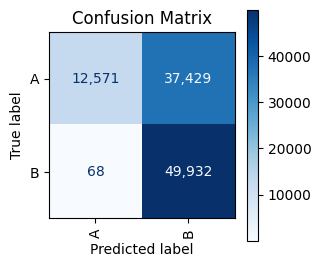

In [7]:
tuner = ClassificationThresholdTuner()

tuner.print_stats_labels(
    y_true=d["Y"],
    target_classes=target_classes,
    y_pred=d["Pred"])

In [11]:
# tuner.print_stats_proba(
#     y_true=d["Y"],
#     target_classes=target_classes,
#     y_pred_proba=d["Pred_Proba"])

100%|██████████| 9/9 [02:18<00:00, 15.34s/it]


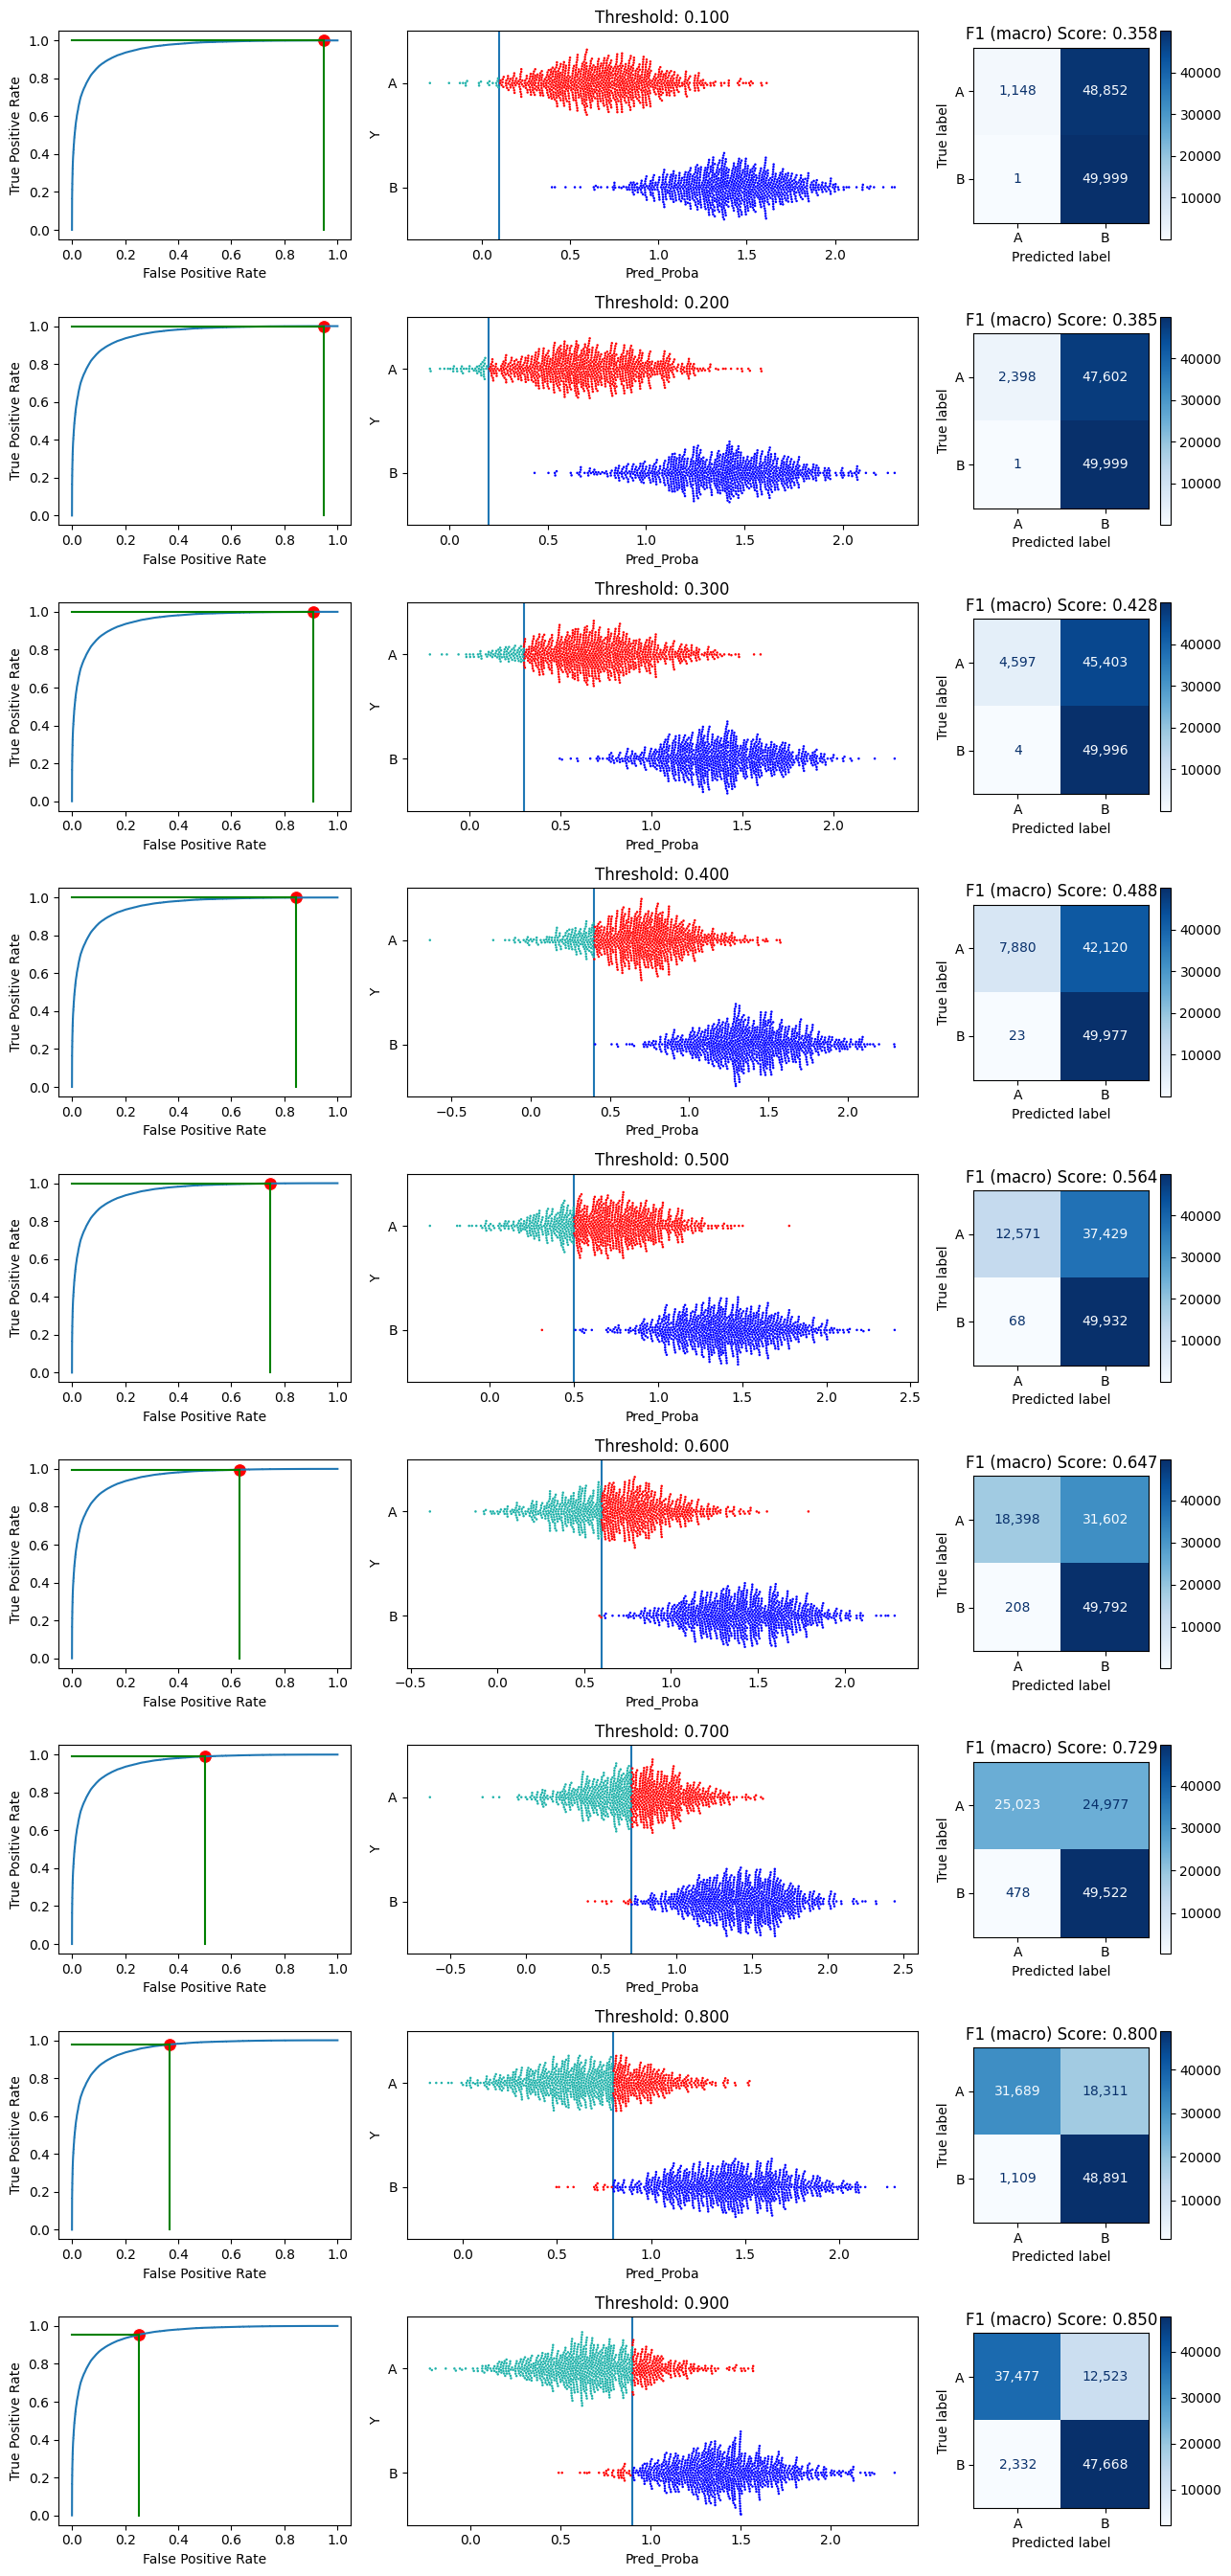

In [9]:
tuner.plot_by_threshold(
    y_true=d['Y'],
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"])

100%|██████████| 6/6 [01:20<00:00, 13.35s/it]


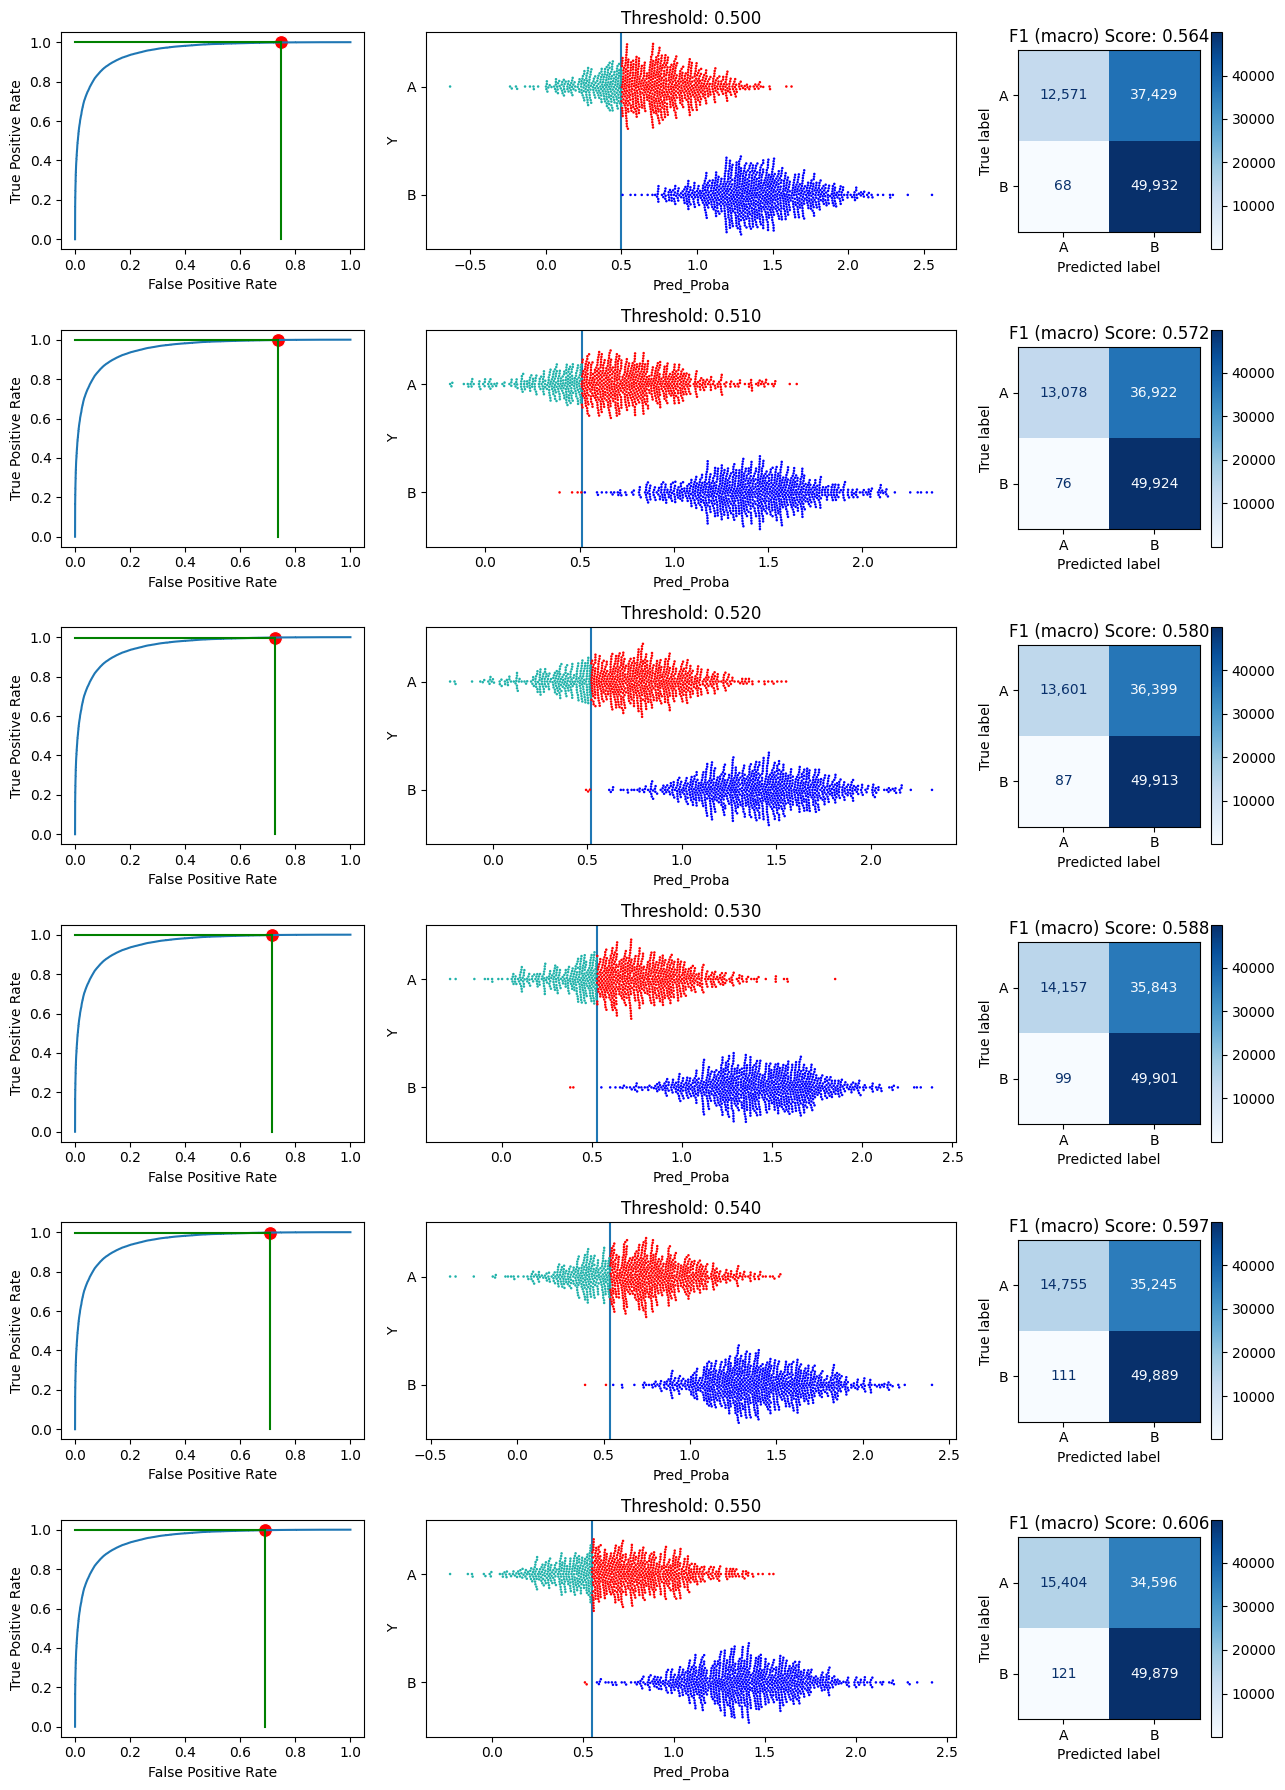

In [10]:
tuner.plot_by_threshold(
    y_true=d['Y'],
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    start=0.50, end=0.55, num_steps=6)

<ipython-input-4-0f93023d5c7a>:728: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,
<ipython-input-4-0f93023d5c7a>:745: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,


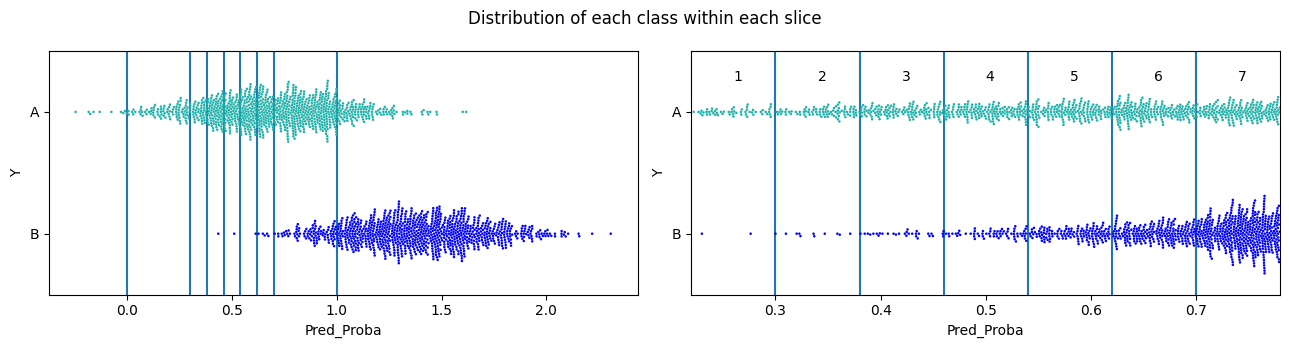

   Slice  Min Prob  Max Prob      A     B  Total  Fraction A  Fraction B
0      1      0.00      0.30   4074     3   4077    0.999264    0.000736
1      2      0.30      0.38   2510    11   2521    0.995637    0.004363
2      3      0.38      0.46   3484    31   3515    0.991181    0.008819
3      4      0.46      0.54   4164    65   4229    0.984630    0.015370
4      5      0.54      0.62   4882   141   5023    0.971929    0.028071
5      6      0.62      0.70   5386   226   5612    0.959729    0.040271
6      7      0.70      1.00  17226  3971  21197    0.812662    0.187338


In [12]:
tuner.describe_slices(
    y_true=d['Y'],
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    start=0.3, end=0.7, num_slices=5)

<ipython-input-4-0f93023d5c7a>:728: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,
<ipython-input-4-0f93023d5c7a>:745: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,


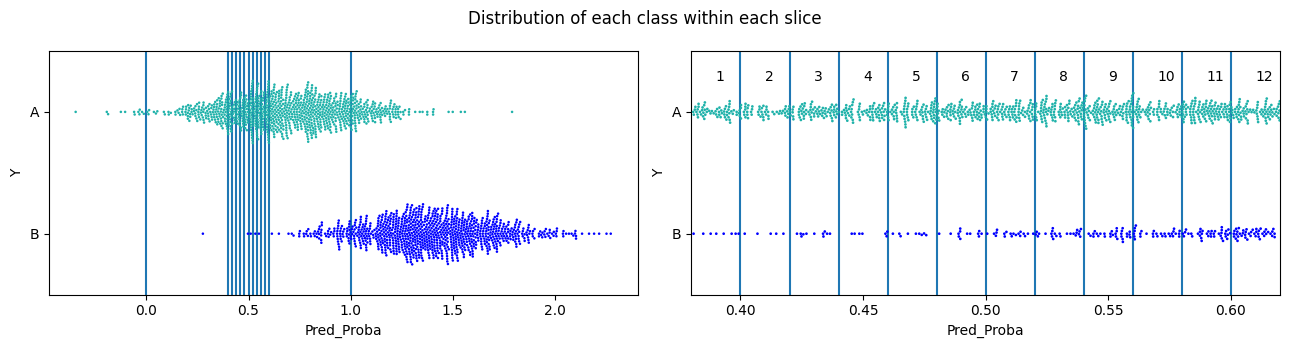

    Slice  Min Prob  Max Prob      A     B  Total  Fraction A  Fraction B
0       1      0.00      0.40   7357    22   7379    0.997019    0.002981
1       2      0.40      0.42    882     5    887    0.994363    0.005637
2       3      0.42      0.44    890    11    901    0.987791    0.012209
3       4      0.44      0.46    939     7    946    0.992600    0.007400
4       5      0.46      0.48    994     9   1003    0.991027    0.008973
5       6      0.48      0.50    986    13    999    0.986987    0.013013
6       7      0.50      0.52   1030    19   1049    0.981888    0.018112
7       8      0.52      0.54   1154    24   1178    0.979626    0.020374
8       9      0.54      0.56   1198    30   1228    0.975570    0.024430
9      10      0.56      0.58   1159    29   1188    0.975589    0.024411
10     11      0.58      0.60   1286    38   1324    0.971299    0.028701
11     12      0.60      1.00  23851  4241  28092    0.849032    0.150968


In [13]:
tuner.describe_slices(
    y_true=d['Y'],
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    start=0.4, end=0.6, num_slices=10)

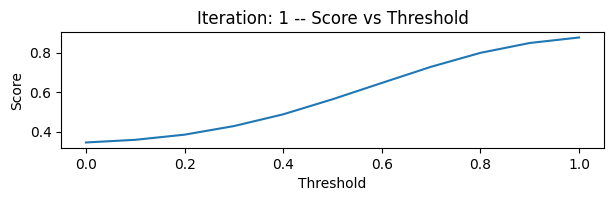

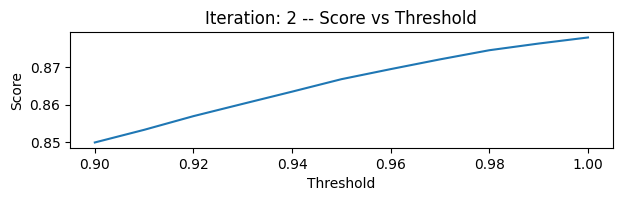

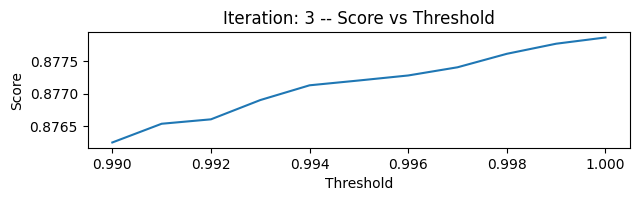

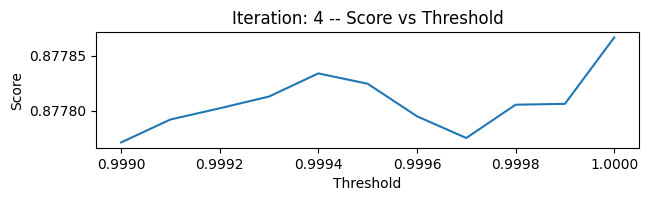

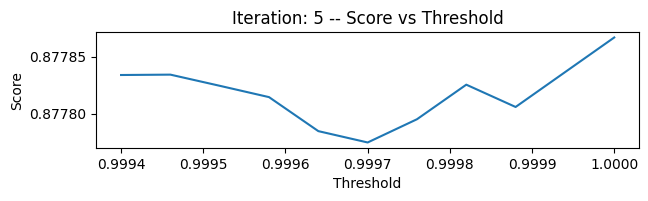

1.0

In [14]:
from sklearn.metrics import f1_score

best_threshold = tuner.tune_threshold(
    y_true=d['Y'],
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    max_iterations=5
)
best_threshold